# **Ensemble Learning in Action**

**Objective**

Build, evaluate, and compare ensemble models while demonstrating an understanding of model mechanics, trade-offs, and business implications.

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score,
                             precision_score, recall_score, confusion_matrix,
                             log_loss, RocCurveDisplay, PrecisionRecallDisplay,
                             DetCurveDisplay, ConfusionMatrixDisplay, brier_score_loss, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier

### Libraries

**Model Selection & Validation**
- cross_val_score: Performs cross-validation to evaluate model performance
- StratifiedKFold: Performs cross-validation that maintains class distributions

**Data Preprocessing**
- ColumnTransformer: Applies different preprocessing to different columns
- OneHotEncoderL Applies one hot encoding
- StandardScaler: Normalizes features to the same scale
- SimpleImputer: Imputes missing values
- Pipeline: Chains preprocessing and modelling steps together

**Model Analysis**
- permutation_importance: Determines feature importance by shuffling features

**Evaluation Metrics**
- accuracy_score
- f1_score
- precision_score
- recall_score
- roc_auc_score
- confusion_matrix
- log_loss
- brier_score_loss

**Classification Algorithms**
- LogisticRegression
- KNeighborsClassifier
- BaggingClassifier
- AdaBoostClassifier
- RandomForestClassifier
- VotingClassifier


In [2]:
# loading data sets
df_train = pd.read_csv('train.csv', delimiter = ';')
df_test = pd.read_csv('test.csv', delimiter = ';')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [3]:
print(f"Training Set NaNs\n{df_train.isnull().sum()}")
print(f"Test Set NaNs\n{df_test.isnull().sum()}") # checking for NaN and nulls

Training Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Test Set NaNs
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [ ]:
# checking for 'unknown' values in categorical columns in training set
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unknown_count = (df_train[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

    

In [ ]:
# checking for 'unknown' values in categorical columns in test set
for col in df_test.columns:
    if df_test[col].dtype == 'object':
        unknown_count = (df_test[col] == 'unknown').sum()
        print(f"{col}: {unknown_count}")

When I first started exploring the class distribution of the output variable, I realized it was an object with a binary response for the observations,'yes' and 'no', which described whether a client subscribed to a term deposit. To make my analysis easier, I defined a dictionary where 'no' equals 0 and 'yes' equals 1 then mapped it to both the training and test sets. Following this, I transformed the output variable from an object to an integer.

In [ ]:
training_conversion_rate = df_train['y'].mean()
print(f"Mean of training set response variable classes {df_train['y'].mean()}")

In [ ]:
print(f"Mean of test set response variable classes {df_test['y'].mean()}")

Both the mean of the training and test set response variable show the majority class is no. This means most clients do not subscribe to a term deposit.

In [ ]:
# defining majority and minority classes for both data sets for exploration
train_majority = df_train[df_train['y'] == 0]
test_majority = df_test[df_test['y'] == 0]

train_minority = df_train[df_train['y'] == 1]
test_minority = df_test[df_test['y'] == 1]

In [ ]:
print(f"Training set majority class dimensions {train_majority.shape}")
print(f"Training set minority class dimensions {train_minority.shape}")

In [ ]:
print(f"The minority class of the training set makes up {5289/39922 * 100:.2f}% of the data")

In [ ]:
print(f"Test set majority class dimensions {test_majority.shape}")
print(f"Test set minority class dimensions {test_minority.shape}")

In [ ]:
print(f"The minority class of the test set makes up {521/4000 *100:.2f}% of the data")

There is a large class imbalance between clients who do subscribe to a term deposit and those who don't. This is a severely class-imbalanced data set.

Data imbalance refers to the concept where a certain output category is underrepresented in a data set. Class-imbalanced data sets are far more common than class-balanced data sets. The goal of training is to create a model that successfully distinguishes the positive class from the negative class. A severely class-imbalanced data set might not contain enough minority class examples for proper training. During training a model should learn what each class looks like (what feature calues correspond to what class) and how common each class is (what is the relative distribution of the classes). These questions can be addressed with a two-step technique downsampling and upweighting the majority class.

**1.** Downsampling the majority class means training on a disproportionately low percentage of majority class observations. I artificially force a class-imbalanced data set to become a little more balanced by omitting majority class examples from training. This increases the likelihood that each batch contains enough obsevations of the minority class to train the model properly. However, downsampling introduces a prediction bias by showing the model an unrealistic reality where the classes are more balanced.

**2.** Upweighting the majority class is where the majority class is weighted by the factor to which it was downsampled. Upweigthing means treating the loss on a majority class observation more harshly than the loss on a minority class observation. This will multiply the loss on one observation by the factor to which the majority class was downsampled. 

Experiment with hyperparameters to determine the factor to use to rebalance the data set. A bonus of this method is faster convergence as the model sees the minority class more often during training. 

**has to be in the model setting, like ensemble learning models**
https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets 

## **Exploratory Data Analysis** 
- Analyze the data set to summarize its main characteristics (use visuals, statistical models)
- I want to see what the data can tell me beyond the formal modelling or hypothesis testing task

**Ask myself** What patterns, anomalies, or relationships exist here that I might not anticipate?

### **Age**

In [ ]:
# I think the best predictors for determining if a direct marketing campaign will result in a client subscribing to a term deposit are:
    # Age (older people), job anyone not 'unknown', 'unemployed', 'student', 'retired'), education (tertiary and secondary), doesn't have credit in default, already has a balance with the bank, duration of the call

df_train['age'].describe()
sns.histplot(df_train['age'])

### **Job**

In [ ]:
df_train['job'].value_counts(normalize=True) * 100 # getting percentage of each class in variable 'job'

In [ ]:
df_train['job'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Jobs')
plt.ylabel('')
plt.show()

### **Education**

In [ ]:
df_train['education'].value_counts(normalize=True) * 100

### **Credit Default**

In [ ]:
df_train['default'].value_counts(normalize=True) * 100

In [ ]:
df_train['default'].value_counts().plot(kind='bar')
plt.title('Distribution of Credit Defaults')
plt.xlabel('Has credit in default')
plt.ylabel('Count')
plt.show()

### **Balance**

In [ ]:
df_train['balance'].describe()

In [ ]:
sns.histplot(df_train['balance']) # there are some unusually high outliers pulling the mean upward
# data is right skewed

In [ ]:
df_train['balance'].mode() # most clients have an average yearly balance of $0 with the bank

In [ ]:
print(f"98th percentile: {df_train['balance'].quantile(0.98):,.2f}") # looking at the 98th quantile
# just below $10,000

In [ ]:
# looking at 99th percentile 
print(f"99th percentile: {df_train['balance'].quantile(0.989):,.2f}") 
# a larger jump, this is a good place to winsorize 

### **Duration of the Call for the Campaign**

In [ ]:
df_train['duration'].describe()

In [ ]:
sns.histplot(df_train['duration']) # right skewed
# most people stay on the phone for less than 4 minutes

In [ ]:
df_train['duration'].mode() # Most people are on the phone for 2 minutes

## **Preparing Data for Linear Model**

**Applying all filters together**
- Keeping clients 35 or older
- Keeping clients who are not retired, students, unemployed, or have an unknown occupation
- Keeping clients with at least secondary education
- Keeping clients who stayed on the phone for at least two minutes (who engaged meaningfully with calls)

## **All Filter Data Set**

In [ ]:
age_filter = df_train['age'] >= 35
job_filter = ~df_train['job'].isin(['unknown', 'unemployed', 'student', 'retired'])
education_filter = ~df_train['education'].isin(['unknown', 'primary'])
duration_filter = df_train['duration'] >= 120

combined_filter = age_filter & job_filter & education_filter & duration_filter
df_filtered_train = df_train[combined_filter].copy()

print(f"Retention Rate: {len(df_filtered_train)/len(df_train)*100:.1f}%") # only about 1/3 of the training set remains after all filters are applied

In [ ]:
sns.histplot(df_filtered_train['balance'])

In [ ]:
# winsorizing at 98th percentile to get a better look at most clients with the bank
# only winsorizing uppe tail because I think negative balances could be a good indicator for future deposit prediction
from scipy.stats import mstats
balance_winsorized_train = mstats.winsorize(df_filtered_train['balance'], limits=[0, 0.02])
sns.histplot(balance_winsorized_train)

**Feature prep for all filter data set**

In [ ]:
df_filtered_train['balance_winsorized'] = mstats.winsorize(df_filtered_train['balance'], limits=[0, 0.02]) # winsorizing balance above 98th percentile

# defining quantitative and qualtitative predictors
numeric_features = ['age', 'balance_winsorized', 'duration'] 
categorical_features = ['job', 'education', 'default']

X_numeric = df_filtered_train[numeric_features]
X_categorical = df_filtered_train[categorical_features]

# one hot encoding categorical variables
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_categorical_encoded = encoder.fit_transform(X_categorical)

categorical_names = encoder.get_feature_names_out(categorical_features)

X_categorical_df = pd.DataFrame(
    X_categorical_encoded,
    columns=categorical_names,
    index=df_filtered_train.index 
)

In [ ]:
# using a linear regression model to assess if the relationship between a client subscribing to more deposits and the data is best described as a linear relationship
import statsmodels.api as sm

X = pd.concat([X_numeric, X_categorical_df], axis=1) # independent variables
y = df_filtered_train['y'] # dependent variable
X = sm.add_constant(X) # adding intercept

lin_model = sm.OLS(y, X).fit()
print(lin_model.summary())


- Low R^2 (0.142) and note from model suggesting strong multicollinearity means I should refine my approach.

**Exploring relationships between categorical variables using chi-squared test**
- Why?

**I have a lot of categorical variables that could influence whether someone subscribes to a term deposit**

**testing independence between categorical variables**
- Do certain types of careers make more deposits? 
- Are married, single, or divorced clients equally likely to make more deposits?
-  Does level of education affect the likelihood of making a deposit?
- Does previous campaign success predict current campaign success?

**If a low p-value (shows strong relationship) then those categorical features are likely influential to the model (if it's a weak relationship, I can consider dropping them)

**business problem**
- Should the bank target specific job categories differently?
- Is marital status relevant for the bank's marketing strategy?

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(df_train['job'], df_train['y']) # creating contingency table
print(contingency_table)

In [ ]:
print(f"Conversion rate (training set): {training_conversion_rate * 100 :.3f}%")

- Careers with above average conversion rates:
    - Students **28.7%**
    - Retired **22.8%**

- Careers with below average conversion rates:
    - Blue-collar **7.3%**
    - Entrepreneur **8.3%**

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"chi-squared statistic {chi2}")
print(f"p-value {p_value}")
print(f"df {dof}")

- p-value < 0.05 so reject the null that career type doesn't influence responding well to campaign

**Career type and responding positively to the campaign are dependent**

The chi-squared test (χ² = 836.11, p < 0.001) provides overwhelming evidence that job type and subscription decisions are strongly related. This suggests that profession is a critical factor in customer behavior and should be prioritized in both feature selection and business strategy."

Marketing Strategy: 
- Target students and retirees (better use of resources, better ROI)
- Reconsider heavily investing in blue-collar workers
- Could try to spend more on management segment because they show promise (13.8% conversion) and a large population

In [ ]:
contingency_table2 = pd.crosstab(df_train['education'], df_train['y']) # creating contingency table
print(contingency_table2)

In [ ]:
print(f"Conversion rate of clients with primary education {(591/6260) * 100 :.3f}%")
print(f"Conversion rate of clients with secondary education {(2450/20752) * 100 :.3f}%")
print(f"Conversion rate of clients with tertiary education {(1996/11305) * 100 :.3f}%")
print(f"Conversion rate of clients with unknown education level {(252/1605) * 100 :.3f}%")

- Education levels with above average conversion rates: **Tertiary, Unknown**

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(contingency_table2)
print(f"chi-squared statistic {chi2}")
print(f"p-value {p_value}")
print(f"df {dof}")

## **Baseline Models**

**Logistic Regression**

In [4]:
df_train['was_previously_contacted'] = (df_train['pdays'] != -1).astype(int) 

In [5]:
# exploring class distribution of dependent variable
dic = {'no': 0, 'yes': 1} # creating binary dictionary for response variable

df_train['y'] = df_train['y'].map(dic)
df_test['y'] = df_test['y'].map(dic)

In [6]:
print("Checking binary columns for issues:")
binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    print(f"{col} unique values: {df_train[col].unique()}")

Checking binary columns for issues:
default unique values: ['no' 'yes']
housing unique values: ['yes' 'no']
loan unique values: ['no' 'yes']


In [7]:
dic_binary = {'no': 0, 'yes': 1}
for col in binary_cols:
    # Add this line to handle any unexpected values
    df_train[col] = df_train[col].fillna('no')  # or check what the actual issue is
    df_train[col] = df_train[col].map(dic_binary)
    df_train[col] = df_train[col].astype(int)

In [23]:
print("Original dataset shape:", df_train.shape)
print(f"Class distribution:\n{df_train['y'].value_counts()}")
print(f"Minority class percentage: {df_train['y'].mean() * 100:.2f}%")

Original dataset shape: (45211, 18)
Class distribution:
y
0    39922
1     5289
Name: count, dtype: int64
Minority class percentage: 11.70%


In [8]:
cat_feats = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']

df_encoded = pd.get_dummies(df_train, columns=cat_feats, drop_first=True) # creating dummy variables

In [9]:
# removing variable 'duration' because I don't know the duration of a call before making the call 
if 'duration' in df_encoded.columns:
    df_encoded = df_encoded.drop('duration', axis=1)

In [10]:
num_feats = ['age', 'balance', 'campaign', 'pdays', 'previous', 'day']

num_feats = [col for col in num_feats if col in df_encoded.columns] # filtering to only include features that exist in the data set

In [11]:
X = df_encoded.drop('y', axis=1) # independent variables
y = df_encoded['y'] # target variable

In [12]:
print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature names: {list(X.columns)}")


Final feature matrix shape: (45211, 42)
Feature names: ['age', 'default', 'balance', 'housing', 'loan', 'day', 'campaign', 'pdays', 'previous', 'was_previously_contacted', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_married', 'marital_single', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_telephone', 'contact_unknown', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [13]:
# standardizing
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[num_feats] = scaler.fit_transform(X[num_feats])


In [14]:
from imblearn.under_sampling import RandomUnderSampler

**Downsampling**
- 88.3% Majority Class
- 11.7% Minority Class

- Downsample the majority class by a factor of 2 artificially creates a more balanced training set (79% : 21%; ratio 3.8:1)
Factor of 2: (88.3/2) : 11.7 = 44.15 : 11.7 → 79% : 21% (ratio 3.8:1)
- 11.7/44.15 = 26.5%

- By a factor of 4 creates a training set 65% : 35%; ratio 1.9:1

In [15]:
rus = RandomUnderSampler(sampling_strategy=0.27, random_state=42) # down sampling the majority class by a factor of 2
# downsampling will introduce a prediction bias by showing the model an artificial world where the classes are more balanced than in reality
# correct this bias by upweighting the majority class by the factor I downsampled by

X_downsampled, y_downsampled = rus.fit_resample(X_scaled, y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.2, random_state=42, stratify=y_downsampled)
# stratify=y maintains the same class proportions as the original data set
# This is useful when classes are imbalanced because it prevents one set from having too few examples of the minority class and ensures the validation set is representative of the data's distribution

In [17]:
lr = LogisticRegression(class_weight={0: 2.0, 1: 1.0}, # upweighting majority class by a factor of 2
                        random_state=42,
                        max_iter=1000
)

lr.fit(X_train, y_train)

LogisticRegression(class_weight={0: 2.0, 1: 1.0}, max_iter=1000,
                   random_state=42)

In [20]:
y_pred = lr.predict(X_test) # making predictions
y_pred_proba = lr.predict_proba(X_test)[:, 1] # probabilities for positive class

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8145


In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.89      3918
           1       0.77      0.18      0.29      1058

    accuracy                           0.81      4976
   macro avg       0.79      0.58      0.59      4976
weighted avg       0.81      0.81      0.77      4976




AUC Score: 0.7673


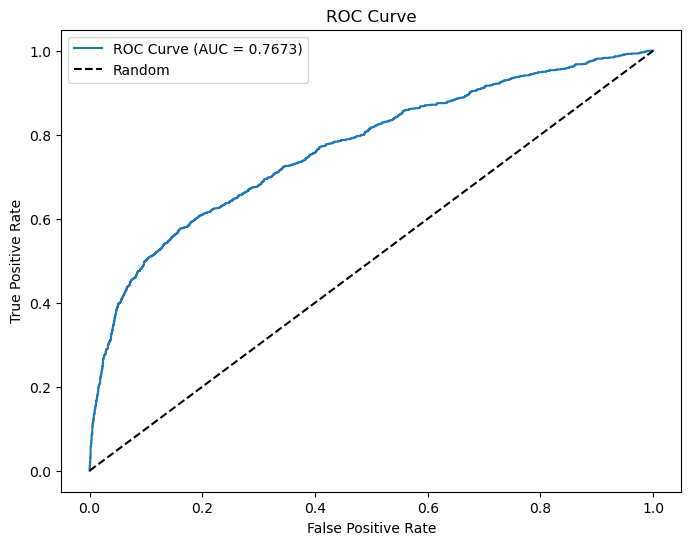

In [25]:
from sklearn.metrics import roc_auc_score, roc_curve

# AUC Score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nAUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [26]:
# Get feature coefficients
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': lr.coef_[0]
})
feature_importance = feature_importance.sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
             feature  coefficient
40  poutcome_success     2.188582
27   contact_unknown    -1.331569
34         month_mar     1.036319
31         month_jan    -1.035515
36         month_nov    -0.855201
28         month_aug    -0.819606
32         month_jul    -0.712808
38         month_sep     0.712581
37         month_oct     0.602066
3            housing    -0.490219
